# 04. Inference

In [1]:
import os
# Set thread usage BEFORE importing tensorflow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["OMP_NUM_THREADS"] = "48"
os.environ["TF_NUM_INTRAOP_THREADS"] = "48"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(48)
tf.config.threading.set_inter_op_parallelism_threads(4)

# Confirm thread settings
print("Intra-op threads:", tf.config.threading.get_intra_op_parallelism_threads())
print("Inter-op threads:", tf.config.threading.get_inter_op_parallelism_threads())

from tensorflow.keras import layers, Model, Input, activations, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset
import tensorflow_probability as tfp
import random, pickle, joblib, numpy as np, wandb, pandas as pd
from wandb.integration.keras import WandbCallback
tfd = tfp.distributions

2025-06-11 10:14:33.916464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 10:14:33.920177: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 10:14:33.924889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 10:14:33.938642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749629673.961351 1593566 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749629673.96

Intra-op threads: 48
Inter-op threads: 4


2025-06-11 10:14:38.553861: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
class MixtureDensityOutput(layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        ) # mix*output vals, no activation
        self.mdn_sigmas = layers.Dense(
            self.num_mix * self.output_dim,
            activation='exponential',
            name="mdn_sigmas",
        ) # mix*output vals exp activation
        self.mdn_pi = layers.Dense(self.num_mix, name="mdn_pi") # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )
    
    def call(self, x):
        return tf.concat(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], axis=-1, name="mdn_outputs"
        )
    
    def compute_output_shape(self, input_shape):
        # input_shape is (batch_size, dense_units)
        batch_size = input_shape[0]
        total_dim  = (2 * self.num_mix * self.output_dim) + self.num_mix
        return (batch_size, total_dim)

def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes])
        y_true = tf.reshape(y_true, [-1, output_dim])

        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = tf.split(y_pred, [num_mixes * output_dim, num_mixes * output_dim, num_mixes], axis=-1)

        # Convert flat vectors into mixture components
        out_mu = tf.reshape(out_mu, [-1, num_mixes, output_dim])
        out_sigma = tf.reshape(out_sigma, [-1, num_mixes, output_dim])

        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        mvn = tfd.MultivariateNormalDiag(loc=out_mu, scale_diag=out_sigma)
        mixture = tfd.MixtureSameFamily(mixture_distribution=cat, components_distribution=mvn)

        # Compute loss
        neg_log_likelihood = - mixture.log_prob(y_true)
        return tf.reduce_mean(neg_log_likelihood)

    return mdn_loss_func

In [2]:
class MixtureDensityOutput(layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        ) # mix*output vals, no activation
        self.mdn_sigmas = layers.Dense(
            self.num_mix * self.output_dim,
            activation='exponential', #elu_plus_one_plus_epsilon,,
            name="mdn_sigmas",
        ) # mix*output vals exp activation
        self.mdn_pi = layers.Dense(self.num_mix, name="mdn_pi") # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )
    
    def call(self, x):
        return tf.concat(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], axis=-1, name="mdn_outputs"
        )
    
    def compute_output_shape(self, input_shape):
        # input_shape is (batch_size, dense_units)
        batch_size = input_shape[0]
        total_dim  = (2 * self.num_mix * self.output_dim) + self.num_mix
        return (batch_size, total_dim)

def get_mixture_loss_func(output_dim, num_mixes, lambda_mse=0.1):
    def mdn_loss_func(y_true, y_pred):
        y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes])
        y_true = tf.reshape(y_true, [-1, output_dim])

        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            [num_mixes * output_dim, num_mixes * output_dim, num_mixes],
            axis=-1
        )

        out_mu = tf.reshape(out_mu, [-1, num_mixes, output_dim])
        out_sigma = tf.reshape(out_sigma, [-1, num_mixes, output_dim])

        cat = tfd.Categorical(logits=out_pi)
        mvn = tfd.MultivariateNormalDiag(loc=out_mu, scale_diag=out_sigma)
        mixture = tfd.MixtureSameFamily(mixture_distribution=cat,
                                        components_distribution=mvn)

        nll = -mixture.log_prob(y_true)
        mdn_nll = tf.reduce_mean(nll)

        pi = tf.nn.softmax(out_pi, axis=-1)
        pi_exp = tf.expand_dims(pi, axis=-1)
        mean_weighted = tf.reduce_sum(pi_exp * out_mu, axis=1)

        mse = tf.reduce_mean(tf.square(mean_weighted - y_true))

        return mdn_nll + lambda_mse * mse
    return mdn_loss_func

In [3]:
# ─── 3) HELPER FUNCTIONS (from the Keras MDN recipe) ───────────────────
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    print("Error sampling categorical model.")
    return -1

def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

def sample_sequences(y_pred, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    batch, T, _ = y_pred.shape
    samples = np.zeros((batch, T, output_dim), dtype=np.float32)
    for b in range(batch):
        for t in range(T):
            samples[b,t] = sample_from_output(
                y_pred[b,t], output_dim, num_mixes,
                temp=temp, sigma_temp=sigma_temp
            )
    return samples

def sample_fan(y_pred, output_dim, num_mixes, N_samples,
               temp=1.0, sigma_temp=1.0):
    batch, T, _ = y_pred.shape
    fan = np.zeros((batch, N_samples, T, output_dim), dtype=np.float32)
    for n in range(N_samples):
        fan[:,n] = sample_sequences(
            y_pred, output_dim, num_mixes,
            temp=temp, sigma_temp=sigma_temp
        )
    return fan

In [57]:
VERSION = "v4"
SUBVERSION = "v4"
RUN_ID = "16"
SEED = 20

EPOCHS = 50
BATCH_SIZE = 512
NUM_MIXTURES = 1
OUTPUT_FEATURES = 3

base = f"/store/fusg/VT1/training/{VERSION}"
load = lambda split, kind: np.load(f"{base}/samples/{split}_{kind}_{SUBVERSION}.npy",
                                   allow_pickle=True).astype("float32")

with open(f"{base}/variables/scaler_in.pkl",  "rb") as f: scaler_in  = pickle.load(f)
with open(f"{base}/variables/scaler_out.pkl", "rb") as f: scaler_out = pickle.load(f)

train_var = load("train", "in_var")
train_con = load("train", "in_con")
train_out = load("train", "out")

val_var   = load("val",   "in_var")
val_con   = load("val",   "in_con")
val_out   = load("val",   "out")

test_var  = load("test",  "in_var")
test_con  = load("test",  "in_con")
test_out  = load("test",  "out")

model = tf.keras.models.load_model(
    f"/store/fusg/VT1/training/models/VT1_LSTM_MDN_Run_{RUN_ID}.keras",
    custom_objects={
        "MixtureDensityOutput": MixtureDensityOutput,
        "mdn_loss_func": get_mixture_loss_func(OUTPUT_FEATURES, NUM_MIXTURES)
    },
    compile=False
)

In [58]:
np.random.seed(SEED)
N_train = train_var.shape[0]
N_val = val_var.shape[0]
N_test = test_var.shape[0]

train_idx = np.random.choice(N_train, int(0.75 * N_train), replace=False)
val_idx = np.random.choice(N_val, int(0.75 * N_val), replace=False)
test_idx = np.random.choice(N_test, int(0.75 * N_test), replace=False)

# --- SUBSAMPLE ---
train_var = train_var[train_idx, :, :3]
train_con = train_con[train_idx]
train_out = train_out[train_idx]

val_var = val_var[val_idx]
val_con = val_con[val_idx]
val_out = val_out[val_idx]

test_var = test_var[test_idx]
test_con = test_con[test_idx]
test_out = test_out[test_idx]

# --- Continue as before ---
print(f"Subsampled train: {len(train_var)} samples")
print(f"Subsampled val:   {len(val_var)} samples")
print(f"Subsampled val:   {len(test_var)} samples")

TIME_STEPS_IN  = train_var.shape[1]
TIME_STEPS_OUT = train_out.shape[1]
VARIABLE_FEATURES = train_var.shape[2]
CONSTANT_FEATURES = train_con.shape[2]
OUTPUT_FEATURES = train_out.shape[2]

Subsampled train: 2880361 samples
Subsampled val:   1088510 samples
Subsampled val:   1008065 samples


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import entropy
from sklearn.metrics import mean_squared_error, mean_absolute_error

tfd = tfp.distributions

# ─── Configuration ────────────────────────────────────────────────────────────
RUNS = [
    {"id": "14", "mixtures": 3, "lambda_mse": 0.2},
    {"id": "16", "mixtures": 1, "lambda_mse": 0.2},
    #{"id": "18", "mixtures": 1, "lambda_mse": 0.0},
]
FEATURES_OUT = 3
BATCH_SIZE   = 512
BASE         = "/store/fusg/VT1/training"
MODEL_DIR    = f"{BASE}/models"
SAMPLE_DIR   = f"{BASE}/v4/samples"

# ─── Load test data ────────────────────────────────────────────────────────────
load = lambda split, kind: np.load(
    f"{SAMPLE_DIR}/{split}_{kind}_v4.npy", allow_pickle=True
).astype("float32")
test_var = load("test", "in_var")
test_con = load("test", "in_con")
test_out = load("test", "out")

# ─── Evaluation loop (vectorized) ─────────────────────────────────────────────
results = []

for run in RUNS:
    run_id  = run["id"]
    M       = run["mixtures"]
    lam     = run["lambda_mse"]

    # Load model (uses existing MixtureDensityOutput & get_mixture_loss_func)
    model = tf.keras.models.load_model(
        f"{MODEL_DIR}/VT1_LSTM_MDN_Run_{run_id}.keras",
        custom_objects={
            "MixtureDensityOutput": MixtureDensityOutput,
            "mdn_loss_func":        get_mixture_loss_func(FEATURES_OUT, M, lam)
        },
        compile=False
    )
    model.compile(loss=get_mixture_loss_func(FEATURES_OUT, M, lam))

    # Predict once
    y_pred = model.predict([test_var, test_con], batch_size=BATCH_SIZE, verbose=0)
    N, T, P = y_pred.shape
    D = FEATURES_OUT

    # Flatten
    flat      = y_pred.reshape(-1, P)        # (N*T, P)
    true_flat = test_out.reshape(-1, D)      # (N*T, D)

    # Extract MDN params
    mu_flat    = flat[:, :M*D].reshape(-1, M, D)
    sigma_flat = flat[:, M*D:2*M*D].reshape(-1, M, D)
    pi_logits  = flat[:, 2*M*D:]             # (N*T, M)

    # Softmax to get pi
    exp_logits = np.exp(pi_logits - np.max(pi_logits, axis=1, keepdims=True))
    pi         = exp_logits / exp_logits.sum(axis=1, keepdims=True)

    # 1) Point forecasts
    pred_mean = np.einsum('jm,jmd->jd', pi, mu_flat)  # weighted average
    rmse      = np.sqrt(mean_squared_error(true_flat, pred_mean))
    mae       = mean_absolute_error(true_flat, pred_mean)

    # 2) NLL (vectorized via TF)
    mus_tf    = tf.constant(mu_flat)
    sigs_tf   = tf.constant(sigma_flat)
    pis_tf    = tf.constant(pi)
    cat       = tfd.Categorical(probs=pis_tf)
    mvn       = tfd.MultivariateNormalDiag(loc=mus_tf, scale_diag=sigs_tf)
    mix       = tfd.MixtureSameFamily(mixture_distribution=cat,
                                      components_distribution=mvn)
    nll       = -mix.log_prob(tf.constant(true_flat))
    mean_nll  = tf.reduce_mean(nll).numpy()

    # 3) 90% coverage (vectorized)
    lower = np.min(mu_flat - 1.645 * sigma_flat, axis=1)  # (N*T, D)
    upper = np.max(mu_flat + 1.645 * sigma_flat, axis=1)  # (N*T, D)
    cov90 = np.mean((true_flat >= lower) & (true_flat <= upper))

    # 4) Mixture stats
    avg_pi     = pi.mean(axis=0)
    mean_ent   = entropy(pi.T).mean()
    usage_frac = np.bincount(pi.argmax(axis=1), minlength=M) / (pi.shape[0])

    # Record
    row = {
        "run_id":     run_id,
        "mixtures":   M,
        "lambda_mse": lam,
        "rmse":       rmse,
        "mae":        mae,
        "nll":        mean_nll,
        "cov_90%":    cov90,
        "mean_ent":   mean_ent,
    }
    for i in range(M):
        row[f"avg_pi_{i}"] = avg_pi[i]
        row[f"usage_{i}"]  = usage_frac[i]
    results.append(row)

# ─── Display results ───────────────────────────────────────────────────────────
df = pd.DataFrame(results)
print(df.to_markdown(index=False))

|   run_id |   mixtures |   lambda_mse |       rmse |         mae |      nll |   cov_90% |   mean_ent |   avg_pi_0 |   usage_0 |    avg_pi_1 |       usage_1 |     avg_pi_2 |       usage_2 |
|---------:|-----------:|-------------:|-----------:|------------:|---------:|----------:|-----------:|-----------:|----------:|------------:|--------------:|-------------:|--------------:|
|       14 |          3 |          0.2 | 0.00287734 | 0.000593013 | -19.7558 |  0.996512 |   0.340557 |   0.204627 |   0.99953 |   0.0597481 |   0.000431166 |   0.00869903 |   3.89075e-05 |
|       16 |          1 |          0.2 | 0.00279345 | 0.000801263 | -15.5515 |  0.974818 |   0        |   1        |   1       | nan         | nan           | nan          | nan           |


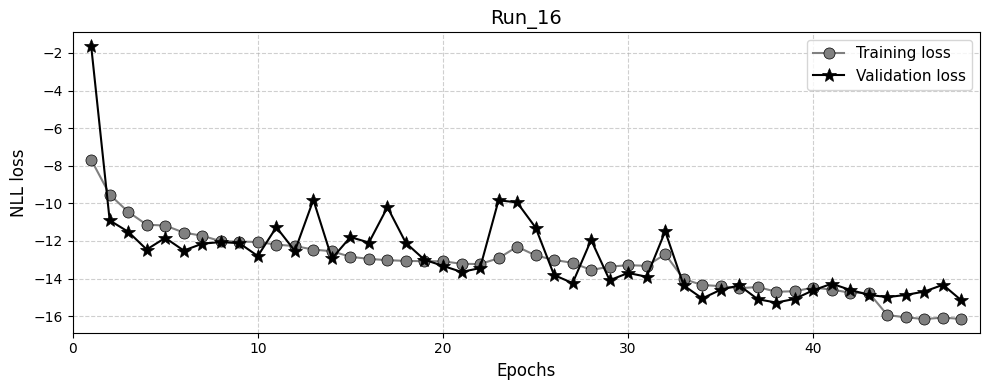

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = f'/store/fusg/VT1/training/models/LSTM_history_run_{RUN_ID}.csv'
df = pd.read_csv(file_path)

# Ensure the columns exist
if 'loss' not in df.columns or 'val_loss' not in df.columns:
    raise ValueError("CSV file must contain 'loss' and 'val_loss' columns.")

# Create the plot
plt.figure(figsize=(10, 4)) # Adjust figure size as needed

# Plot Training loss with gray circles
plt.plot(df.index+1, df['loss'], marker='o', linestyle='-', color='gray', label='Training loss', markersize=8, markeredgecolor='black', markeredgewidth=0.5)

# Plot Validation loss with black stars
plt.plot(df.index+1, df['val_loss'], marker='*', linestyle='-', color='black', label='Validation loss', markersize=10, markeredgecolor='black', markeredgewidth=0.5)

# Add title and labels
plt.title(f'Run_{RUN_ID}', fontsize=14) # Changed title to Run_5 based on the requested filename
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('NLL loss', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=11)

# Set y-axis limits to roughly match the example, adjust if your data range is different
# You might need to adjust these based on your actual data values
# For example, if your data goes down to -20, adjust the lower limit
# plt.ylim(top=min(df['loss'].max(), df['val_loss'].max()) + 1,
#          bottom=max(df['loss'].min(), df['val_loss'].min()) - 1)

# You can also set x-axis limits if needed, for example, to show only a certain number of epochs
plt.xlim(0, len(df)+1)

# Display the plot
plt.tight_layout() # Adjusts plot to ensure everything fits
plt.show()

In [46]:
# FOR LSTM WITHOUT MDN
import matplotlib.pyplot as plt

sample_idx = random.randint(0, len(test_var) - 1)

# (1, T_in, 3)
x_enc = test_var[sample_idx:sample_idx+1, :, :]  # Añade batch dim
c_enc = test_con[sample_idx:sample_idx+1]                      # (1, 1, 20)
y_true = test_out[sample_idx, :, :OUTPUT_FEATURES]             # (T_out, 3)

# Predicción SOLO de esa muestra
y_pred = model.predict([x_enc, c_enc])[0]                      # (T_out, 3)

for j, name in enumerate(['latitude_scaled', 'longitude_scaled', 'altitude_scaled']):
    plt.figure(figsize=(12, 4))
    # Input (historia)
    plt.plot(range(-x_enc.shape[1]+1, 1), x_enc[0, :, j], 'bo-', label='Input (hist)')
    # Ground Truth
    plt.plot(range(0, y_true.shape[0]), y_true[:, j], 'r^-', label='Ground Truth', alpha=0.7)
    # Predicción
    plt.plot(range(0, y_pred.shape[0]), y_pred[:, j], 'g--', label='Prediction', linewidth=2)
    plt.title(f"Sample {sample_idx} — {name}")
    plt.xlabel("Timestep")
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

ValueError: Input 1 of layer "functional" is incompatible with the layer: expected shape=(None, 61, 3), found shape=(1, 1, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


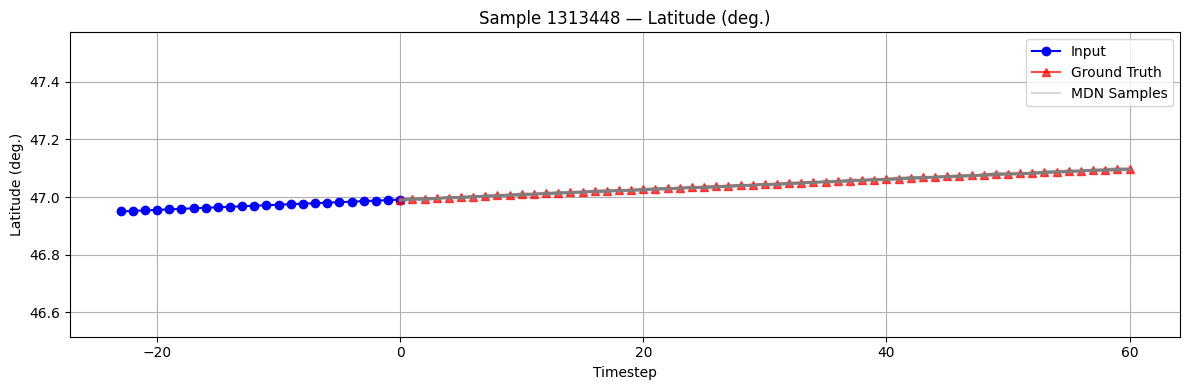

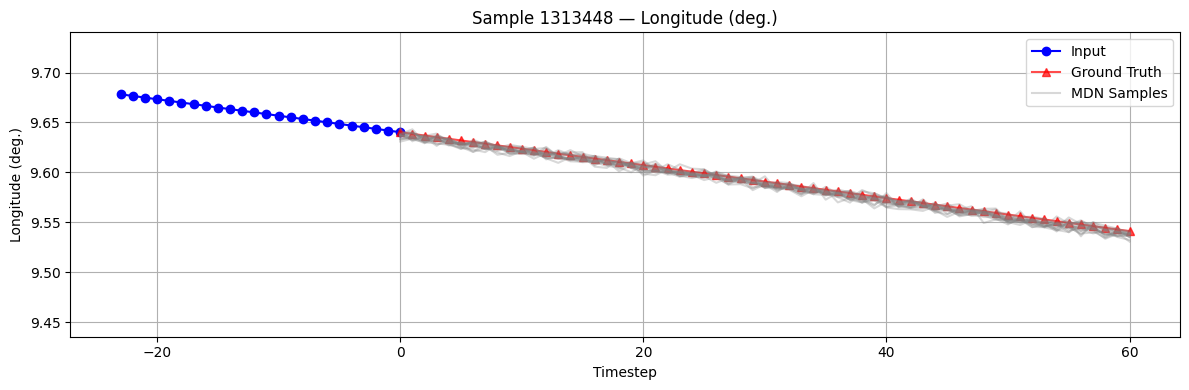

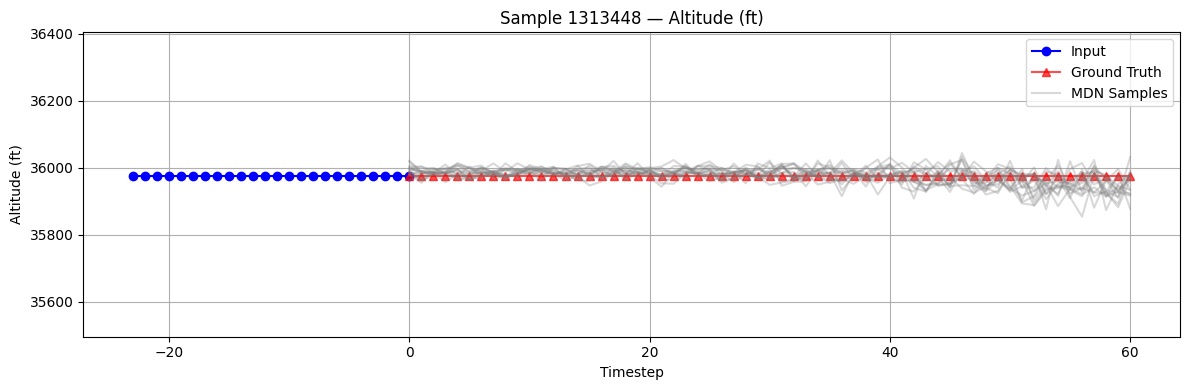

In [11]:
# FOR LSTM WITH MDN
import matplotlib.pyplot as plt
sample_idx = random.randint(0, len(test_var) - 1)
#sample_idx = 153298
#sample_idx = 41008
#sample_idx = 310519

# (1, T_in, VARS)
x_enc = test_var[sample_idx:sample_idx+1, :, :]   # (1, T_in, VARS)
c_enc = test_con[sample_idx:sample_idx+1]         # (1, 1, CONST_FEATS)
y_true = test_out[sample_idx, :, :OUTPUT_FEATURES]  # (T_out, 3)

y_pred_params = model.predict([x_enc, c_enc])      # (1, T_out, PARAMS)

N_SAMPLES = 15
mdn_samples = sample_fan(y_pred_params, OUTPUT_FEATURES, NUM_MIXTURES, N_SAMPLES, temp=0.1, sigma_temp=0.2)

K = 1 # Batch size (from x_enc, which is 1)
T_out = y_true.shape[0] # Number of time steps in the output
D = OUTPUT_FEATURES # Number of output features (e.g., 3 for lat/lon/alt)
num_in_cols = 8 # As provided in your request

flat_preds = mdn_samples[0].reshape(-1, D) # Reshape (N_SAMPLES, T_out, D) to (N_SAMPLES * T_out, D)
true_output_scaled = y_true # y_true is already your scaled true output
sample_var_scaled = x_enc[0, :, :] # Extract the single sample's input variables (T_in, VARS)

pred_unscaled = scaler_out.inverse_transform(flat_preds).reshape(N_SAMPLES, T_out, D)
true_unscaled = scaler_out.inverse_transform(true_output_scaled)
input_unscaled = scaler_in.inverse_transform(sample_var_scaled[:, :num_in_cols])[:, :D]

for j, name in enumerate(['Latitude (deg.)', 'Longitude (deg.)', 'Altitude (ft)']):
    # Determine the unscaled name for the plot title and ylabel

    plt.figure(figsize=(12, 4))
    # Input (hist) - NOW USING UNCALED DATA
    plt.plot(range(-x_enc.shape[1]+1, 1), input_unscaled[:, j], 'bo-', label='Input')

    # Ground truth - NOW USING UNCALED DATA
    plt.plot(range(0, true_unscaled.shape[0]), true_unscaled[:, j], 'r^-', label='Ground Truth', alpha=0.7)

    # Varias muestras MDN (con poca alpha para ver la dispersión) - NOW USING UNCALED DATA
    for n in range(N_SAMPLES):
        plt.plot(range(0, true_unscaled.shape[0]), pred_unscaled[n, :, j], '-', color='gray', alpha=0.3 if N_SAMPLES > 1 else 1,
                 linewidth=1.5, label='MDN Samples' if n == 0 else None)

    plt.title(f"Sample {sample_idx} — {name}")
    plt.xlabel("Timestep")
    plt.ylabel(name)
    plt.legend()
    factor = 0.01

    plt.ylim([np.min(pred_unscaled[:, :, j])*(1-factor), np.max(pred_unscaled[:, :, j])*(1+factor)])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
# y_pred shape = (N, T_out, 2*mix*D + mix)
y_pred = model.predict([test_var, test_con])

# since mix=1, means = y_pred[..., :D]
pred_means = y_pred[..., :OUTPUT_FEATURES]
rmse = np.sqrt(((pred_means - test_out)**2).mean())
mae  = np.abs(pred_means - test_out).mean()
print(f"Val RMSE = {rmse:.4f}, MAE = {mae:.4f}")

42003/42003 ━━━━━━━━━━━━━━━━━━━━ 646s 15ms/step
Val RMSE = 0.0029, MAE = 0.0011


In [10]:
# FIRST POINT OF OUTPUT
print(y_true[0])
print(true_unscaled[0])

# LAST POINT OF INPUT
print(input_unscaled[-1])
print(x_enc[0,-1,:3])

[0.4136439  0.37114924 0.7254902 ]
[4.6133011e+01 6.9355202e+00 3.8000004e+04]
[4.6133011e+01 6.9355202e+00 3.8000004e+04]
[0.4136439  0.37114924 0.7254902 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


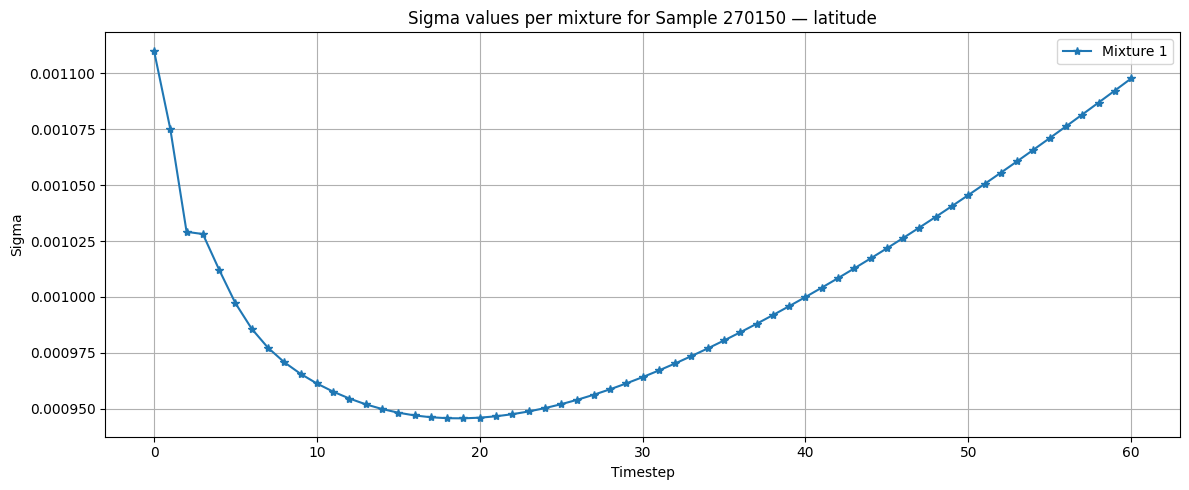

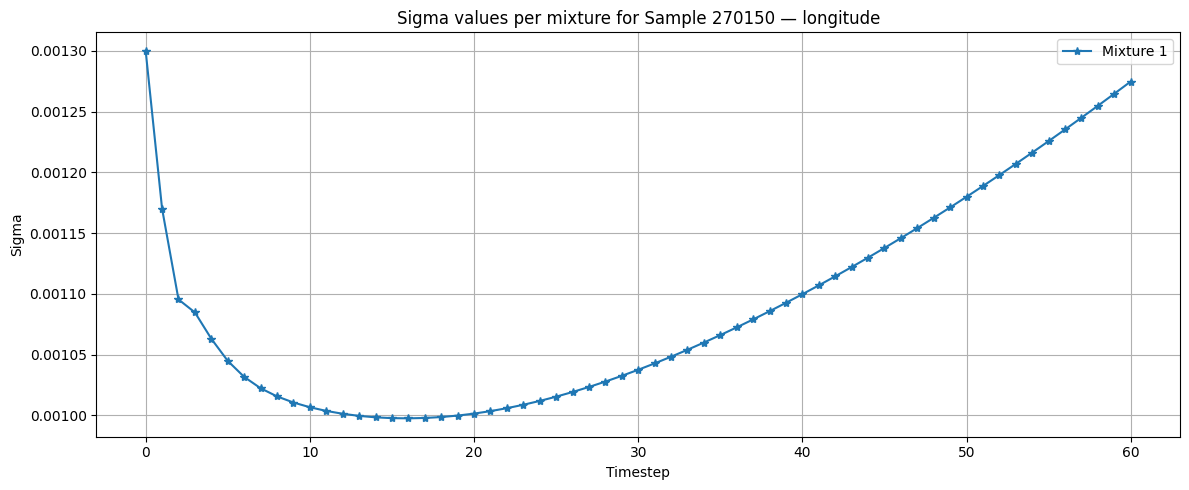

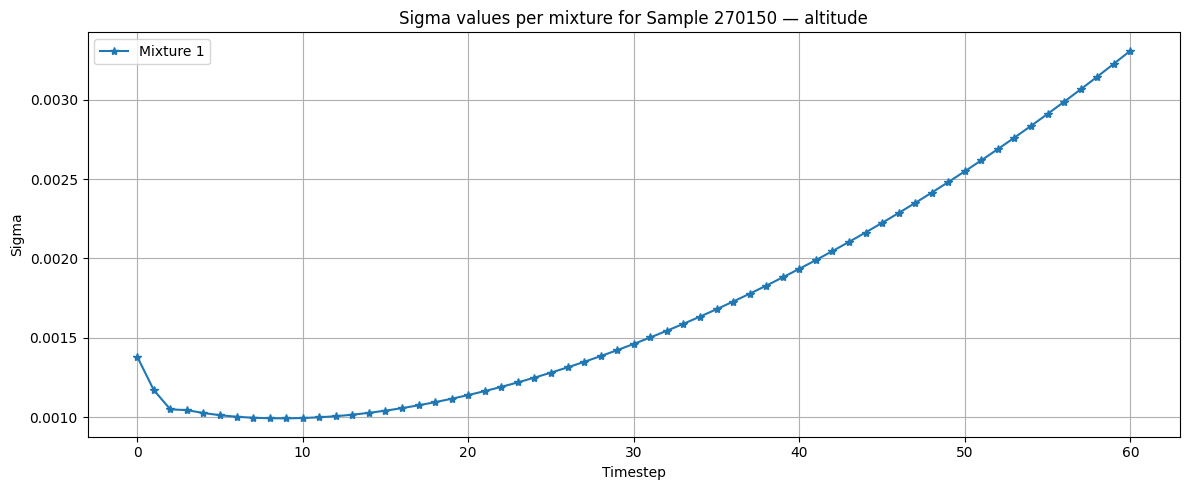

In [20]:
import numpy as np
import matplotlib.pyplot as plt

#sample_idx = 153298  # or pick randomly
sample_idx = random.randint(0, len(test_var) - 1)

# Get your MDN outputs: shape (1, T_out, num_mixtures * output_dim * 3)
mdn_pred = model.predict([x_enc, c_enc])  # shape: (1, T_out, ...)
mdn_pred = mdn_pred[0]  # Remove batch dim: (T_out, num_mixtures * output_dim * 3)

num_mixtures = NUM_MIXTURES
output_dim = 3  # latitude, longitude, altitude

# Helper to extract sigma values for one output dimension
def extract_sigmas(mdn_pred, dim, num_mixtures, output_dim):
    # For each output, the order is [means..., sigmas..., weights...]
    # Common format: [mu1, mu2, mu3, sigma1, sigma2, sigma3, alpha1, alpha2, alpha3] for output_dim=1
    T_out = mdn_pred.shape[0]
    sigma_start = num_mixtures * output_dim
    sigma_end = 2 * num_mixtures * output_dim
    sigmas = []
    for t in range(T_out):
        # Extract sigmas for this output dimension and timestep
        s = []
        for k in range(num_mixtures):
            idx = sigma_start + dim * num_mixtures + k
            s.append(mdn_pred[t, idx])
        sigmas.append(s)
    return np.array(sigmas)  # shape: (T_out, num_mixtures)

output_names = ['latitude', 'longitude', 'altitude']

for dim, name in enumerate(output_names):
    sigmas = extract_sigmas(mdn_pred, dim, num_mixtures, output_dim)  # shape: (T_out, num_mixtures)

    plt.figure(figsize=(12, 5))
    for k in range(num_mixtures):
        plt.plot(range(sigmas.shape[0]), sigmas[:, k], marker='*', label=f'Mixture {k+1}')
    plt.xlabel('Timestep')
    plt.ylabel('Sigma')
    plt.title(f'Sigma values per mixture for Sample {sample_idx} — {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


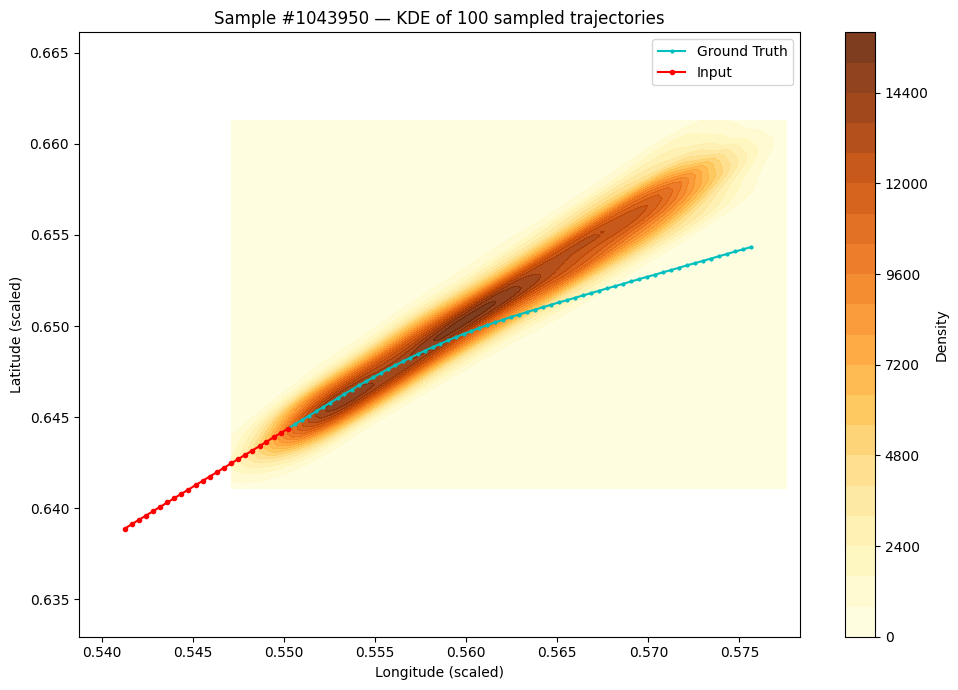

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx   = random.randint(0, len(test_var) - 1)
#sample_idx = 153299
#sample_idx = 41008
#sample_idx = 103459

K            = 100
sigma_temp   = 1.0
temp         = 0.6

# ─── Constants ───────────────────────────────────────────────────────────
OUTPUT_DIM     = OUTPUT_FEATURES
NUM_MIXTURES   = NUM_MIXTURES
TIME_STEPS_IN  = test_var.shape[1]
TIME_STEPS_OUT = test_out.shape[1]

# ─── 1) Predict MDN parameters ───────────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]
x_con = test_con[sample_idx:sample_idx+1]        # (1, 1, const_feats)
y_pred = model.predict([x_var, x_con])           # (1, T_out, param_dim)

# ─── 2) Sample K trajectories from MDN ───────────────────────────────────
fan = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = temp,
    sigma_temp   = sigma_temp
)  # shape: (1, K, T_out, 3)
fan = fan[0]  # shape: (K, T_out, 3)

# ─── 3) Obtener el input y la trayectoria real ───────────────────────────
history    = test_var[sample_idx, :, :OUTPUT_DIM]    # (T_hist, 3)
gt_scaled  = test_out[sample_idx, :, :OUTPUT_DIM]    # (T_out, 3)

# ─── 4) KDE sobre todos los puntos predichos ─────────────────────────────
all_latlon = fan[:, :, :3].reshape(-1, 3)  # (K*T_out, 3)
lat_vals   = all_latlon[:, 0]
lon_vals   = all_latlon[:, 1]

xy = np.vstack([lon_vals, lat_vals])
kde = gaussian_kde(xy)
xmin, xmax = lon_vals.min(), lon_vals.max()
ymin, ymax = lat_vals.min(), lat_vals.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# ─── 5) Visualización KDE + Trayectorias ─────────────────────────────────
plt.figure(figsize=(10, 7))

# a) mapa de densidad de los puntos
plt.contourf(X, Y, Z, levels=20, cmap="YlOrBr", alpha=0.9)

# b) ground truth trajectory (scaled)
plt.plot(gt_scaled[:,1], gt_scaled[:,0], 'c.-', label='Ground Truth', markersize=4)

# c) input trajectory
plt.plot(history[:,1], history[:,0], 'ro-', label='Input', markersize=3)

# d) muestras individuales (opcional)
# for i in range(min(K, 30)):
#     plt.plot(fan[i,:,1], fan[i,:,0], color="gray", alpha=0.2, linewidth=1)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
#plt.ylabel('Altitude (scaled)')
plt.title(f"Sample #{sample_idx} — KDE of {K} sampled trajectories")
plt.axis("equal")
plt.colorbar(label="Density")
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


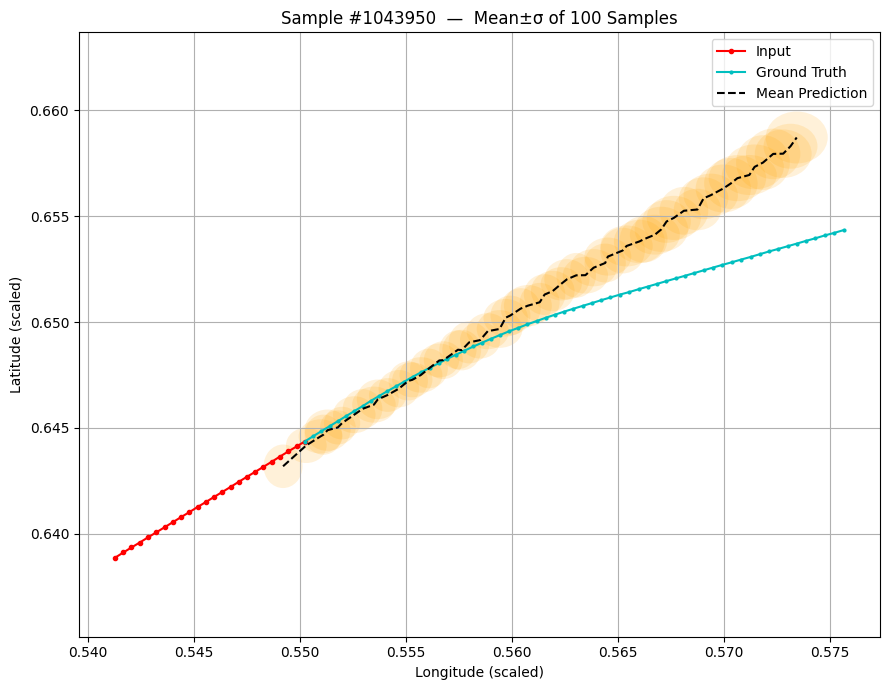

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from scipy.stats import gaussian_kde

# ─── User parameters ─────────────────────────────────────────────────────
#sample_idx   = random.randint(0, len(test_var) - 1)
# sample_idx = 153299
# sample_idx = 41008
#sample_idx = 103459
#sample_idx = 291493

K            = 100
sigma_temp   = 1.0
temp         = 0.1

# ─── Constants ───────────────────────────────────────────────────────────
OUTPUT_DIM     = OUTPUT_FEATURES
NUM_MIXTURES   = NUM_MIXTURES
TIME_STEPS_IN  = test_var.shape[1]
TIME_STEPS_OUT = test_out.shape[1]

# ─── 1) Predict MDN parameters ───────────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]                 # (1, T_in, dim_in)
x_con = test_con[sample_idx:sample_idx+1]                 # (1, 1, const_feats)
y_pred = model.predict([x_var, x_con])                    # (1, T_out, param_dim)

# ─── 2) Sample K trajectories from MDN ───────────────────────────────────
fan = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = temp,
    sigma_temp   = sigma_temp
)  # shape: (1, K, T_out, 3)
fan = fan[0]  # now shape: (K, T_out, 3)

# ─── 3) Extract “history” (input) and “ground truth” ────────────────────
history   = test_var[sample_idx, :, :OUTPUT_DIM]   # (T_hist, 3), [:,0]=lat, [:,1]=lon
gt_scaled = test_out[sample_idx, :, :OUTPUT_DIM]   # (T_out, 3), [:,0]=lat, [:,1]=lon

# ─── 4) Compute per‐timestep mean & σ for lat/lon ────────────────────────
lat_samples = fan[:, :, 0]   # (K, T_out)
lon_samples = fan[:, :, 1]   # (K, T_out)

mu_lat    = lat_samples.mean(axis=0)    # (T_out,)
sigma_lat = lat_samples.std(axis=0)     # (T_out,)

mu_lon    = lon_samples.mean(axis=0)    # (T_out,)
sigma_lon = lon_samples.std(axis=0)     # (T_out,)

time_idx = np.arange(TIME_STEPS_OUT)    # [0, 1, 2, …, T_out‐1]

# ─── 5) Plot everything on one spatial figure ───────────────────────────
plt.figure(figsize=(9, 7))

# a) Plot input trajectory (history)
plt.plot(history[:,1], history[:,0], 'ro-', label='Input', markersize=3)

# b) Plot ground‐truth future trajectory
plt.plot(gt_scaled[:,1], gt_scaled[:,0], 'c.-', label='Ground Truth', markersize=4)

# c) Plot mean of MDN samples (dashed)
plt.plot(mu_lon, mu_lat, 'k--', label='Mean Prediction')

# d) At each output timestep, draw a ±1σ ellipse
for t in range(TIME_STEPS_OUT):
    ellipse = patches.Ellipse(
        (mu_lon[t], mu_lat[t]),
        width  = 2 * sigma_lon[t],    # full width = 2·σ_lon
        height = 2 * sigma_lat[t],    # full height = 2·σ_lat
        angle  = 0,
        alpha  = 0.15,
        facecolor='orange',
        edgecolor='none'
    )
    plt.gca().add_patch(ellipse)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title(f"Sample #{sample_idx}  —  Mean±σ of {K} Samples")
plt.axis("equal")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

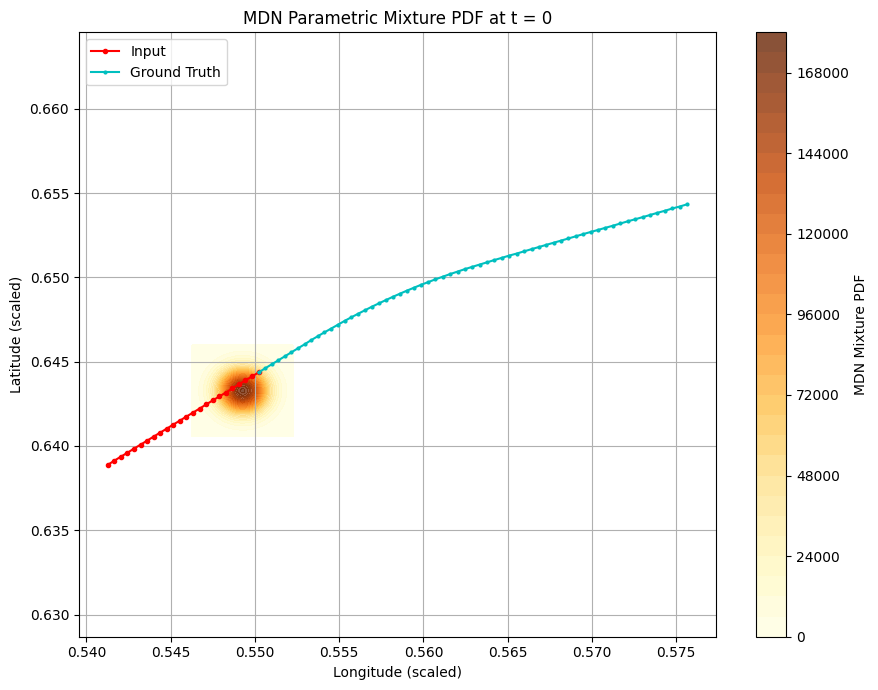

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

t_idx = 0
_, T_out, param_dim = y_pred.shape
D = 3
M = param_dim // (1 + 2*D)
θ_t = y_pred[0, t_idx, :]

raw_mus, raw_sigs, raw_pi_logits = split_mixture_params(θ_t, OUTPUT_DIM, NUM_MIXTURES)

# (a) Reshape mus → (M, D)
mus = raw_mus.reshape(M, D)
# (b) Reshape sigs → (M, D)
sigs = raw_sigs.reshape(M, D)

# (c) Convert logits → actual mixture weights π₁…π_M with the same softmax(…, t=temp) that sample_fan uses
pis = softmax(raw_pi_logits, t=temp)

mu_lats = mus[:, 0].copy()
mu_lons = mus[:, 1].copy()
sigma_lats = sigs[:, 0].copy()
sigma_lons = sigs[:, 1].copy()

# ─── 5) Build a lon–lat grid spanning ±3σ around every mixture center
lat_min = (mu_lats - 3 * sigma_lats).min()
lat_max = (mu_lats + 3 * sigma_lats).max()
lon_min = (mu_lons - 3 * sigma_lons).min()
lon_max = (mu_lons + 3 * sigma_lons).max()

n_grid = 200
lat_lin = np.linspace(lat_min, lat_max, n_grid)
lon_lin = np.linspace(lon_min, lon_max, n_grid)
LON, LAT = np.meshgrid(lon_lin, lat_lin)
pos = np.dstack((LON, LAT))   # shape = (n_grid, n_grid, 2)

# ─── 6) Evaluate the mixture PDF at each grid point:
pdf = np.zeros((n_grid, n_grid))
for i in range(M):
    mean_i = [mu_lons[i], mu_lats[i]]  
    cov_i = np.diag([sigma_lons[i]**2, sigma_lats[i]**2])
    rv_i = multivariate_normal(mean=mean_i, cov=cov_i)
    pdf += pis[i] * rv_i.pdf(pos)

# ─── 7) Plot the contour‐filled MDN mixture PDF + overlay Input & Ground Truth
plt.figure(figsize=(9, 7))

cf = plt.contourf(lon_lin, lat_lin, pdf, levels=30, cmap="YlOrBr", alpha=0.8)
plt.colorbar(cf, label="MDN Mixture PDF")

# a) Plot input “history” in red
plt.plot(history[:, 1], history[:, 0], "ro-", label="Input", markersize=3)

# b) Plot ground‐truth future in cyan
plt.plot(gt_scaled[:, 1], gt_scaled[:, 0], "c.-", label="Ground Truth", markersize=4)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title(f"MDN Parametric Mixture PDF at t = {t_idx}")
plt.axis("equal")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

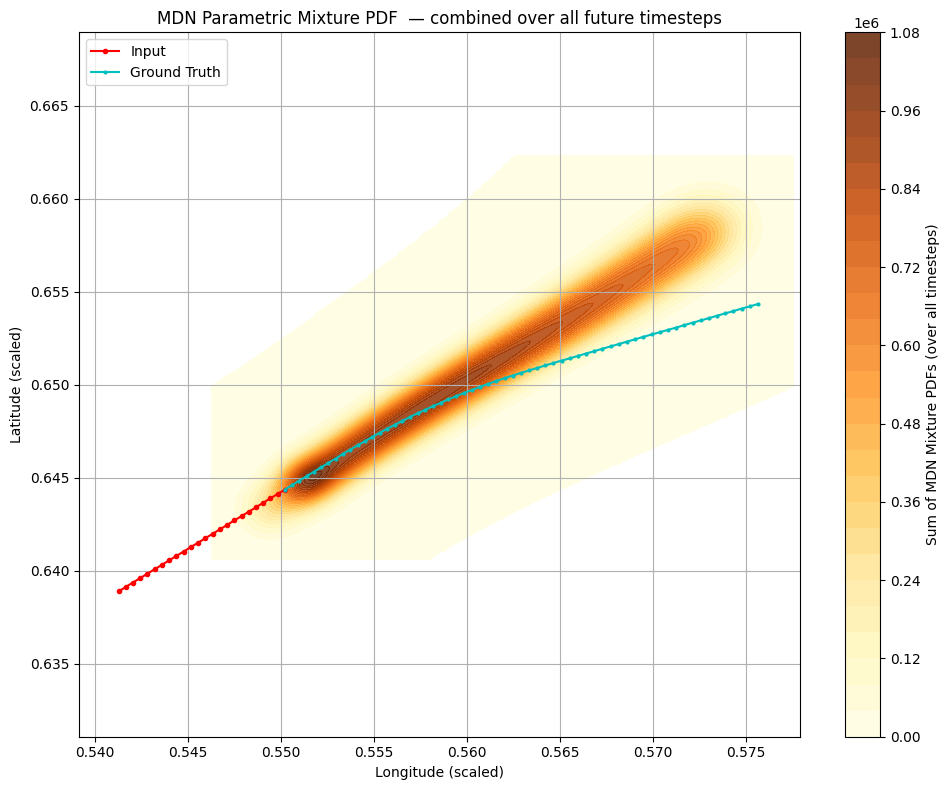

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# ─── 1) Get basic shapes and constants
_, T_out, param_dim = y_pred.shape
D = OUTPUT_DIM      # = 3 (lat, lon, alt)
M = NUM_MIXTURES    # number of Gaussians per timestep
temp = 0.1          # same temperature used for sampling

# ─── 2) Pre‐allocate arrays to store (μ_lat, μ_lon, σ_lat, σ_lon) for every t, every i
# Shapes: (T_out, M)
all_mu_lats    = np.zeros((T_out, M), dtype=np.float32)
all_mu_lons    = np.zeros((T_out, M), dtype=np.float32)
all_sigma_lats = np.zeros((T_out, M), dtype=np.float32)
all_sigma_lons = np.zeros((T_out, M), dtype=np.float32)

# We don’t strictly need to store all π’s at once, but we will recompute them when building pdf
# If you want, you could also store all pis in an array of shape (T_out, M).

# ─── 3) Loop over timesteps to extract and store (μ, σ)
for t_idx in range(T_out):
    θ_t = y_pred[0, t_idx, :]  # shape = (M + 3M + 3M) = (7M,)

    # 3a) Split into raw_mus, raw_sigs, raw_pi_logits
    raw_mus, raw_sigs, raw_pi_logits = split_mixture_params(θ_t, D, M)
    mus = raw_mus.reshape(M, D)     # each row = [μ_latᵢ, μ_lonᵢ, μ_altᵢ]
    sigs = raw_sigs.reshape(M, D)   # each row = [σ_latᵢ, σ_lonᵢ, σ_altᵢ]

    # 3b) Fill our arrays for lat & lon
    all_mu_lats[t_idx, :]    = mus[:, 0]
    all_mu_lons[t_idx, :]    = mus[:, 1]
    all_sigma_lats[t_idx, :] = sigs[:, 0]
    all_sigma_lons[t_idx, :] = sigs[:, 1]

# ─── 4) Determine global lon/lat min/max over all timesteps & components
lat_min = (all_mu_lats - 3 * all_sigma_lats).min()
lat_max = (all_mu_lats + 3 * all_sigma_lats).max()
lon_min = (all_mu_lons - 3 * all_sigma_lons).min()
lon_max = (all_mu_lons + 3 * all_sigma_lons).max()

# ─── 5) Build one 2D grid covering that entire range
n_grid = 250
lat_lin = np.linspace(lat_min, lat_max, n_grid)
lon_lin = np.linspace(lon_min, lon_max, n_grid)
LON, LAT = np.meshgrid(lon_lin, lat_lin)      # shape = (n_grid, n_grid)
pos = np.dstack((LON, LAT))                  # shape = (n_grid, n_grid, 2)

# ─── 6) Initialize a zero‐array to accumulate the sum of all Gaussians over time
pdf_total = np.zeros((n_grid, n_grid), dtype=np.float64)

# ─── 7) Again loop over each timestep and each component to add its weighted PDF
for t_idx in range(T_out):
    θ_t = y_pred[0, t_idx, :]
    raw_mus, raw_sigs, raw_pi_logits = split_mixture_params(θ_t, D, M)
    mus = raw_mus.reshape(M, D)
    sigs = raw_sigs.reshape(M, D)
    pis = softmax(raw_pi_logits, t=temp)   # mixture‐weights at this timestep

    # For each mixture component i at this t_idx, add pis[i]·N_i to pdf_total
    for i in range(M):
        # Extract mean and sigma for component i at timestep t_idx
        μ_lat_i = mus[i, 0]
        μ_lon_i = mus[i, 1]
        σ_lat_i = sigs[i, 0]
        σ_lon_i = sigs[i, 1]

        # Build 2×2 covariance from (σ_lon_i, σ_lat_i)
        mean_i = [μ_lon_i, μ_lat_i]  # note ordering: [lon, lat]
        cov_i = np.diag([σ_lon_i**2, σ_lat_i**2])

        rv_i = multivariate_normal(mean=mean_i, cov=cov_i)
        # Evaluate on the entire grid, multiply by weight
        pdf_comp = rv_i.pdf(pos) * pis[i]
        pdf_total += pdf_comp

# If you prefer the _average_ across timesteps instead of sum, uncomment:
# pdf_total /= T_out

# ─── 8) Plot the aggregated heatmap + overlay input & full ground‐truth
plt.figure(figsize=(10, 8))

masked_pdf = np.ma.masked_where(pdf_total <= 1e-8, pdf_total)
cf = plt.contourf(lon_lin, lat_lin, masked_pdf, levels=30, cmap="YlOrBr", alpha=0.85, vmin=0)
cf.cmap.set_under("white")
cf.set_clim(vmin=masked_pdf.min(), vmax=masked_pdf.max())
plt.colorbar(cf, label="Sum of MDN Mixture PDFs (over all timesteps)")

# a) Plot the **entire** input “history” in red
plt.plot(history[:, 1], history[:, 0], "ro-", label="Input", markersize=3)

# b) Plot the **entire** ground‐truth future (all T_out points) in cyan
plt.plot(gt_scaled[:, 1], gt_scaled[:, 0], "c.-", label="Ground Truth", markersize=4)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title("MDN Parametric Mixture PDF  — combined over all future timesteps")
plt.axis("equal")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


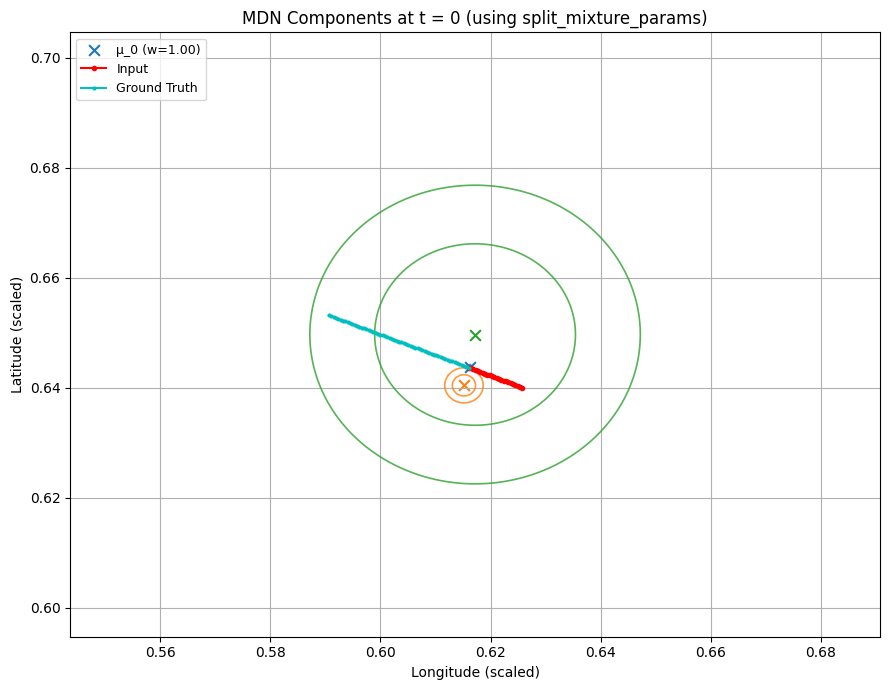

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# ─── 1) Pick the same future timestep t_idx that you want to visualize ──
t_idx = 0
temp  = 0.1   # same temperature you used for sampling

# ─── 2) Extract raw MDN parameters from y_pred at t_idx, then split them ───
_, T_out, param_dim = y_pred.shape
D = OUTPUT_DIM      # in your case D == 3 (lat, lon, alt)
M = NUM_MIXTURES    # number of Gaussian components

θ_t = y_pred[0, t_idx, :]   # shape = (M + 3M + 3M,) = (7M,)

# Reuse your helper to split into flat arrays:
raw_mus, raw_sigs, raw_pi_logits = split_mixture_params(θ_t, D, M)
# raw_mus  has length M*D
# raw_sigs has length M*D
# raw_pi_logits has length M

# (a) Reshape mus → (M, D) and sigs → (M, D)
mus   = raw_mus.reshape(M, D)    # mus[i] = [μ_latᵢ, μ_lonᵢ, μ_altᵢ]
sigs  = raw_sigs.reshape(M, D)   # sigs[i] = [σ_latᵢ, σ_lonᵢ, σ_altᵢ]

# (b) Compute mixture weights with the same softmax(temp) you use during sampling
pis = softmax(raw_pi_logits, t=temp)   # shape = (M,)

# ─── 3) Extract each component’s latitude/longitude mean and σ ─────────────
mu_lats   = mus[:, 0].copy()    # (M,) 
mu_lons   = mus[:, 1].copy()
sigma_lats = sigs[:, 0].copy()
sigma_lons = sigs[:, 1].copy()

# ─── 4) Build a “shared” lon–lat grid that spans ±3σ around every component ─
lat_min = (mu_lats - 3*sigma_lats).min()
lat_max = (mu_lats + 3*sigma_lats).max()
lon_min = (mu_lons - 3*sigma_lons).min()
lon_max = (mu_lons + 3*sigma_lons).max()

n_grid = 200
lat_lin = np.linspace(lat_min, lat_max, n_grid)
lon_lin = np.linspace(lon_min, lon_max, n_grid)
LON, LAT = np.meshgrid(lon_lin, lat_lin)
pos = np.dstack((LON, LAT))   # shape = (n_grid, n_grid, 2)

# ─── 5) Plot each component’s weighted contour + its mean, all on one figure ─
plt.figure(figsize=(9, 7))

for i in range(M):
    mean_i = [mu_lons[i], mu_lats[i]]  
    cov_i  = np.diag([sigma_lons[i]**2, sigma_lats[i]**2])
    rv_i   = multivariate_normal(mean=mean_i, cov=cov_i)

    # Evaluate just this component’s weighted PDF on the grid
    Zi = rv_i.pdf(pos) * pis[i]

    # Pick 3 contour‐levels (skip the zero‐level so lines aren’t too dense)
    levels = np.linspace(Zi.min(), Zi.max(), 4)[1:]

    plt.contour(
        lon_lin,
        lat_lin,
        Zi,
        levels=levels,
        colors=[plt.cm.tab10(i % 10)],
        linewidths=1.2,
        alpha=0.8,
    )

    # Mark the component’s mean with an “×”
    plt.scatter(
        mean_i[0],
        mean_i[1],
        marker="x",
        color=plt.cm.tab10(i % 10),
        s=60,
        label=f"μ_{i} (w={pis[i]:.2f})" if i == 0 else None
        # only label the first component so the legend isn’t huge
    )

# ─── 6) Overlay your input & ground‐truth trajectories ─────────────────────
plt.plot(history[:, 1], history[:, 0], "ro-", label="Input", markersize=3)
plt.plot(gt_scaled[:, 1], gt_scaled[:, 0], "c.-", label="Ground Truth", markersize=4)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title(f"MDN Components at t = {t_idx} (using split_mixture_params)")
plt.legend(loc="upper left", fontsize=9)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Statistics

In [ ]:
x_var = test_var
x_con = test_con
y_pred = model.predict([x_var, x_con])

   29/12799 ━━━━━━━━━━━━━━━━━━━━ 2:54 14ms/step

 5255/12799 ━━━━━━━━━━━━━━━━━━━━ 1:48 14ms/step

In [ ]:
N, T_out, _ = y_pred.shape
D = OUTPUT_FEATURES
M = NUM_MIXTURES

y_true = test_out
N, T_out, _ = y_pred.shape
D, M = OUTPUT_FEATURES, NUM_MIXTURES

# ── split μ, σ, π ───────────────────────────────────────────────
flat        = y_pred.reshape(-1, (2*M*D) + M)
mu          = flat[:, :M*D            ].reshape(N, T_out, M, D)
sigma       = flat[:, M*D:2*M*D       ].reshape(N, T_out, M, D)
pi_logits   = flat[:, 2*M*D:          ].reshape(N, T_out, M)
pi          = tf.nn.softmax(pi_logits, axis=-1).numpy()          # (N,T,M)

In [ ]:
print("μ  (mean |μ|)         :", np.abs(mu).mean())
print("σ  (mean)             :", sigma.mean())
print("π  (avg max weight)   :", pi.max(-1).mean())

μ  (mean |μ|)         : 0.51572585
σ  (mean)             : 0.00791106
π  (avg max weight)   : 0.93222934


In [ ]:
# Component usage and MAE
k_star = pi.argmax(-1)  # (N, T) -> index of dominant component
y_mix  = (pi[..., None] * mu).sum(2)  # (N, T, D)
errors = y_true - y_mix

for k in range(M):
    mask = (k_star == k)
    usage = mask.mean() * 100
    mae   = np.abs(errors[mask]).mean()
    print(f"Mix {k}: selected in {usage:5.1f}% of steps · MAE = {mae:.4f}")

Mix 0: selected in  98.0% of steps · MAE = 0.0009
Mix 1: selected in   0.0% of steps · MAE = nan
Mix 2: selected in   2.0% of steps · MAE = 0.0030


/tmp/ipykernel_3444568/1349881912.py:9: RuntimeWarning: Mean of empty slice.
  mae   = np.abs(errors[mask]).mean()
/home/fusg/.conda/envs/tf-mdn/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for k in range(NUM_MIXTURES):
    mean_pi = pi[:, :, k].mean()
    std_pi  = pi[:, :, k].std()
    max_pi  = pi[:, :, k].max()
    min_pi  = pi[:, :, k].min()
    print(f"Mixture {k}: π mean = {mean_pi:.4f}, std = {std_pi:.4f}, min = {min_pi:.4f}, max = {max_pi:.4f}")

Mixture 0: π mean = 0.9280, std = 0.1166, min = 0.0012, max = 0.9995
Mixture 1: π mean = 0.0107, std = 0.0104, min = 0.0003, max = 0.1435
Mixture 2: π mean = 0.0613, std = 0.1081, min = 0.0001, max = 0.9807


In [ ]:
# Entropy and effective # of components
entropy = (-pi * np.log(pi + 1e-8)).sum(-1)     # (N, T)
eff_k   = np.exp(entropy).mean()
print("Average π entropy       :", entropy.mean())
print("Effective # of mixtures :", eff_k)

Average π entropy       : 0.22294159
Effective # of mixtures : 1.2774191


In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

print("σ · global stats:")
print("  min:", sigma.min())
print("  max:", sigma.max())
print("  mean:", sigma.mean())
print("  std :", sigma.std())

# Residual correlation between lat/lon
residuals = errors.reshape(-1, D)
corr_lat_lon = np.corrcoef(residuals[:, 0], residuals[:, 1])[0, 1]
print("Residual correlation (lat-lon):", corr_lat_lon)

σ · global stats:
  min: 0.001
  max: 1.4436316
  mean: 0.00791106
  std : 0.009581539
Residual correlation (lat-lon): -0.13388491235265795


12799/12799 ━━━━━━━━━━━━━━━━━━━━ 132s 10ms/step


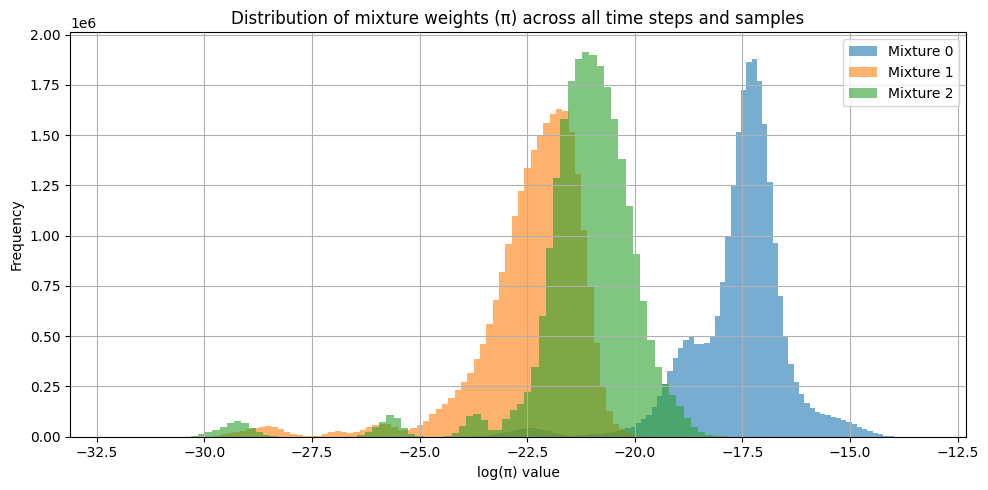

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_var = test_var
x_con = test_con
y_pred = model.predict([x_var, x_con])

# Supón que ya tienes y_pred de forma (N, T, param_dim)
flat = y_pred.reshape(-1, y_pred.shape[-1])  # (N*T, param_dim)
_, _, pi_logits = split_mixture_params(flat.T, OUTPUT_FEATURES, NUM_MIXTURES)
pis = softmax(pi_logits.T)  # shape: (N*T, M)

# Plot histogram of π for each mixture
plt.figure(figsize=(10, 5))
for m in range(NUM_MIXTURES):
    plt.hist(np.log(pis[:,m]), bins=100, alpha=0.6, label=f"Mixture {m}")

plt.title("Distribution of mixture weights (π) across all time steps and samples")
plt.xlabel("log(π) value")
plt.ylabel("Frequency") 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plots

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx   = 685714 #random.randint(0, len(test_var) - 1)
K            = 100
sigma_temp   = 1.0
temp         = 0.1

# ─── Constants ───────────────────────────────────────────────────────────
OUTPUT_DIM     = OUTPUT_FEATURES    # should be 3
NUM_MIXTURES   = NUM_MIXTURES       # e.g. 7
TIME_STEPS_IN  = test_var.shape[1]
TIME_STEPS_OUT = test_out.shape[1]

# ─── 1) Predict MDN and sample deltas ────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)
y_pred = model.predict((x_var, x_con))

fan = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = temp,
    sigma_temp   = sigma_temp
)  # shape: (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history       = test_var[sample_idx, :, :OUTPUT_DIM]  # (T_hist,3)
# y0            = history[-1]                           # starting point
# pred_samples  = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

# for k in range(K):
#     deltas = fan[0, k]  # (T_fut, 3)
#     traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)
#     traj[0] = y0
#     for t in range(1, TIME_STEPS_OUT):
#         traj[t] = traj[t-1] + deltas[t]
#     pred_samples[k] = traj

# ─── 3) Reunir todos los puntos (lat, lon) ───────────────────────────────
all_latlon = fan[0, :, :, :2].reshape(-1, 2)  # shape: (K*T_out, 2)
lat_vals   = all_latlon[:, 0]
lon_vals   = all_latlon[:, 1]

# ─── 4) KDE sobre todos los puntos predichos ─────────────────────────────
xy = np.vstack([lon_vals, lat_vals])
kde = gaussian_kde(xy)
xmin, xmax = lon_vals.min(), lon_vals.max()
ymin, ymax = lat_vals.min(), lat_vals.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# ─── 5) Visualización KDE + Trayectorias ─────────────────────────────────
plt.figure(figsize=(10, 7))

# a) mapa de densidad de los puntos
plt.contourf(X, Y, Z, levels=20, cmap="YlOrBr", alpha=0.9)

# b) ground truth trajectory (scaled)
gt_scaled = test_out[sample_idx]
plt.plot(gt_scaled[:,1], gt_scaled[:,0], 'c.-', label='Ground Truth', markersize=4)

# c) input trajectory
plt.plot(history[:,1], history[:,0], 'ro-', label='Input', markersize=3)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title(f"Sample #{sample_idx} — KDE of {K} sampled trajectories (delta mode)")
plt.axis("equal")
plt.colorbar(label="Density")
plt.legend()
plt.tight_layout()
plt.show()

2025-06-03 23:28:40.336142: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/fusg/.conda/envs/tf-mdn/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


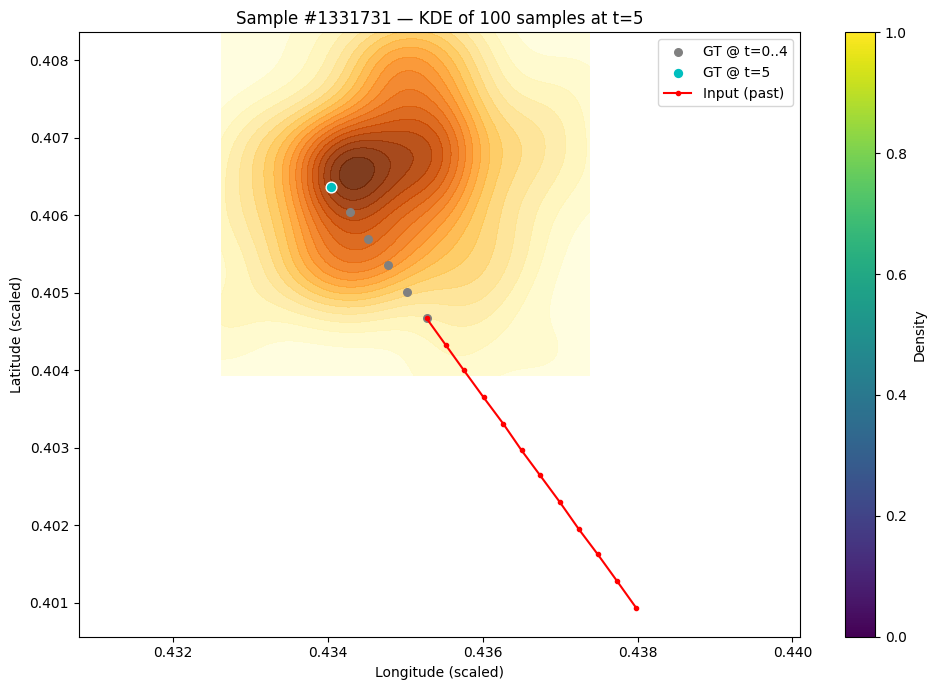

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx = random.randint(0, len(test_var) - 1)
K          = 100
sigma_temp = 1.0
temp       = 0.1

# ─── Constants ───────────────────────────────────────────────────────────
OUTPUT_DIM     = OUTPUT_FEATURES    # should be 3
NUM_MIXTURES   = NUM_MIXTURES       # e.g. 7
TIME_STEPS_IN  = test_var.shape[1]
TIME_STEPS_OUT = test_out.shape[1]

# ─── 0) Choose which future time-step you want (0-based) ─────────────────
t_sel = 5   # for example, the 6th future point (must be < TIME_STEPS_OUT)

# ─── 1) Predict MDN and sample deltas ────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)
y_pred = model.predict((x_var, x_con))

fan = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = temp,
    sigma_temp   = sigma_temp
)  # shape: (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history      = test_var[sample_idx, :, :OUTPUT_DIM]   # (T_hist, 3)
# y0           = history[-1]                            # starting point
# pred_samples = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

# for k in range(K):
#     deltas = fan[0, k]  # (T_fut, 3)
#     traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)
#     traj[0] = y0
#     for t in range(1, TIME_STEPS_OUT):
#         traj[t] = traj[t - 1] + deltas[t]
#     pred_samples[k] = traj

# ─── 3) Extract just the lat/lon at t_sel ───────────────────────────────
#    pred_samples has shape (K, T_out, 3), so we take pred_samples[:, t_sel, :2].
points_at_t = fan[0, :, t_sel, :2]  # shape: (K, 2)

lat_vals = points_at_t[:, 0]
lon_vals = points_at_t[:, 1]

# ─── 4) KDE over only those K points ────────────────────────────────────
xy = np.vstack([lon_vals, lat_vals])
kde = gaussian_kde(xy)

xmin, xmax = lon_vals.min(), lon_vals.max()
ymin, ymax = lat_vals.min(), lat_vals.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# ─── 5) Visualization ───────────────────────────────────────────────────
plt.figure(figsize=(10, 7))

# a) density of the K points at t_sel
plt.contourf(X, Y, Z, levels=20, cmap="YlOrBr", alpha=0.9)

# b) ground truth from t=0 to t_sel-1 (in grey)
gt_full = test_out[sample_idx]         # shape: (TIME_STEPS_OUT, 3)
if t_sel > 0:
    gt_past = gt_full[:t_sel, :2]      # (lat, lon) for times 0..t_sel-1
    plt.scatter(
        gt_past[:, 1],                  # longitudes of t=0..t_sel-1
        gt_past[:, 0],                  # latitudes of t=0..t_sel-1
        c='gray',
        s=30,
        label=f"GT @ t=0..{t_sel-1}"
    )

# c) ground truth at exactly t_sel (in cyan)
gt_point_sel = gt_full[t_sel, :2]      # (lat, lon) at t_sel
plt.scatter(
    gt_point_sel[1],                    # longitude at t_sel
    gt_point_sel[0],                    # latitude at t_sel
    c='c',
    s=60,
    edgecolors='white',
    label=f'GT @ t={t_sel}'
)

# d) input (past) trajectory (unchanged)
plt.plot(
    history[:, 1],                      # input longitudes
    history[:, 0],                      # input latitudes
    'ro-', 
    label='Input (past)', 
    markersize=3
)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.title(f"Sample #{sample_idx} — KDE of {K} samples at t={t_sel}")
plt.axis("equal")
plt.colorbar(label="Density")
plt.legend()
plt.tight_layout()
plt.show()

In [607]:
def mdn_log_likelihood(y_pred, samples, output_dim, num_mixes):
    T = y_pred.shape[1]
    K = samples.shape[0]

    # Squeeze batch dim
    y_pred_single = np.squeeze(y_pred, axis=0)  # (T, P)
    flat = y_pred_single.reshape(T, -1)

    mu        = flat[:, :num_mixes * output_dim].reshape(T, num_mixes, output_dim)
    sigma     = flat[:, num_mixes * output_dim:2 * num_mixes * output_dim].reshape(T, num_mixes, output_dim)
    pi_logits = flat[:, 2 * num_mixes * output_dim:].reshape(T, num_mixes)

    # Build T distributions
    distributions = []
    for t in range(T):
        cat = tfd.Categorical(logits=pi_logits[t])
        comp = tfd.MultivariateNormalDiag(loc=mu[t], scale_diag=sigma[t])
        mix = tfd.MixtureSameFamily(mixture_distribution=cat, components_distribution=comp)
        distributions.append(mix)

    # Compute log-likelihood
    total_log_prob = 0.0
    for k in range(K):
        for t in range(T):
            total_log_prob += distributions[t].log_prob(samples[k, t])
    
    return total_log_prob / (K * T)

logp = mdn_log_likelihood(y_pred, fan[0, :, :, :], OUTPUT_FEATURES, NUM_MIXTURES)
print(f"Avg log-likelihood over {K} samples: {logp:.4f}")

Avg log-likelihood over 100 samples: 16.3736


In [608]:
print("σ mean over time:", sigma.mean(axis=(0,1)))
print("σ min / max:", sigma.min(), sigma.max())

σ mean over time: [[0.00049164 0.00045511 0.00047987]]
σ min / max: 0.001 0.18140745


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


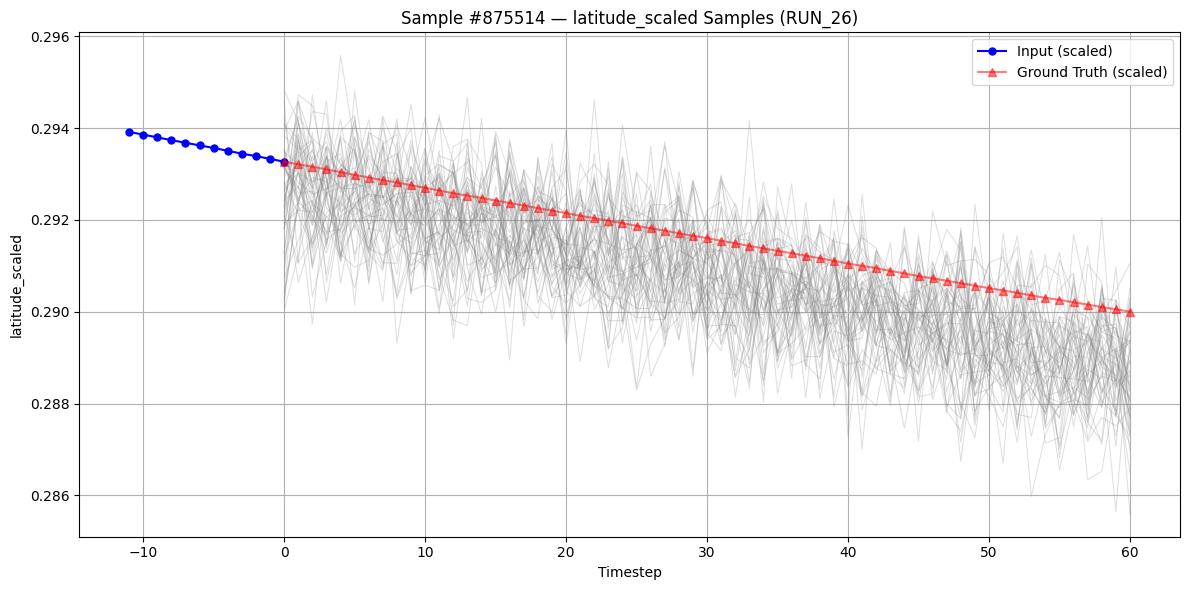

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx   = random.randint(0, len(test_var) - 1)
K            =  50
sigma_temp   = 1.0
feature_index = 0      # 0=latitude_scaled, 1=longitude_scaled, 2=altitude_scaled

# ─── Constants from your setup ────────────────────────────────────────────
output_features = ['latitude_scaled', 'longitude_scaled', 'altitude_scaled']
feature_name    = output_features[feature_index]
TIME_STEPS_IN   = test_var.shape[1]
TIME_STEPS_OUT  = test_out.shape[1]
OUTPUT_DIM      = OUTPUT_FEATURES
NUM_MIXTURES    = NUM_MIXTURES

# ─── 1) MDN predict + fan of deltas ───────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]              # (1, T_hist, 3)
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)  # (1, C)

y_pred = model.predict((x_var, x_con))                # (1, T_fut, param_dim)
fan    = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = 0.1,
    sigma_temp   = sigma_temp
)                                                     # shape (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history       = test_var[sample_idx, :, :OUTPUT_DIM]  # (T_hist,3)
# y0            = history[-1]                          # last observed point, shape (3,)
# pred_samples  = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

# for k in range(K):
#     deltas = fan[0, k]                               # (T_fut,3)
#     traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), float)
#     traj[0]= y0                                      # start at persistence baseline
#     for t in range(1, TIME_STEPS_OUT):
#         traj[t] = traj[t-1] + deltas[t]
#     pred_samples[k] = traj

# ─── 3) Prepare plotting axes ────────────────────────────────────────────
true_output_scaled = test_out[sample_idx]             # (T_fut,3)
sample_var_scaled  = history                          # alias for clarity

t_input  = list(range(-TIME_STEPS_IN + 1, 1))         # e.g. [-11,…,0]
t_output = list(range(0, TIME_STEPS_OUT))             # [0,…,T_fut-1]

# ─── 4) Plot in order: a) samples, b) input, c) ground truth ─────────────
plt.figure(figsize=(12,6))

# a) sampled trajectories
for k in range(K):
    plt.plot(t_output, fan[0, k, :, feature_index], color="gray", alpha=0.25, linewidth=0.75)

plt.plot(t_input,
         sample_var_scaled[:, feature_index],'bo-', label="Input (scaled)", markersize=5)

# c) ground truth
plt.plot(t_output,
         true_output_scaled[:, feature_index],'r^-', label="Ground Truth (scaled)", alpha=0.5, markersize=6)

plt.title(f"Sample #{sample_idx} — {feature_name} Samples (RUN_{RUN_ID})")
plt.xlabel("Timestep")
plt.ylabel(feature_name)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


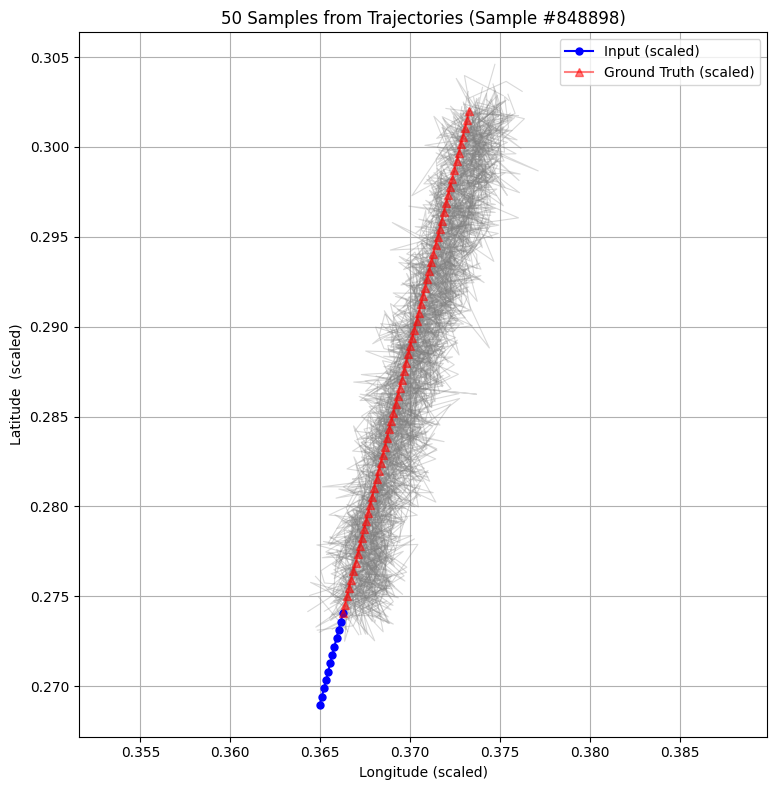

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx   = random.randint(0, len(test_var) - 1)
K            = 50
sigma_temp   = 1.0

# ─── Constants from your setup ────────────────────────────────────────────
TIME_STEPS_IN   = test_var.shape[1]
TIME_STEPS_OUT  = test_out.shape[1]
OUTPUT_DIM      = OUTPUT_FEATURES # should be 3 (lat, long, alt)
NUM_MIXTURES    = NUM_MIXTURES

# ─── 1) MDN predict + fan of deltas ───────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]              
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)

y_pred = model.predict((x_var, x_con))                
fan    = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = 0.2,
    sigma_temp   = sigma_temp
)  # shape (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history      = test_var[sample_idx, :, :OUTPUT_DIM]  
# y0           = history[-1]                          
# pred_samples = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

# for k in range(K):
#     deltas = fan[0, k]                           
#     traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), float)
#     traj[0]= y0                                  
#     for t in range(1, TIME_STEPS_OUT):
#         traj[t] = traj[t-1] + deltas[t]
#     pred_samples[k] = traj

# ─── 3) Extract ground truth & history ────────────────────────────────────
gt          = test_out[sample_idx]
input_hist  = history

# ─── 4) Plot 2D trajectories: lon on x-axis, lat on y-axis ───────────────
plt.figure(figsize=(8,8))

# a) sampled fans
for k in range(K):
    traj = fan[0, k]
    plt.plot(traj[:,1], traj[:,0],
             color='gray', alpha=0.3, linewidth=0.8)

# b) input history
plt.plot(input_hist[:,1], input_hist[:,0],
         'bo-', label="Input (scaled)", markersize=5)

# c) ground truth future
plt.plot(gt[:,1], gt[:,0],
         'r^-', label="Ground Truth (scaled)", alpha=0.5, markersize=6)

plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude  (scaled)")
plt.title(f"{K} Samples from Trajectories (Sample #{sample_idx})")
plt.legend()
plt.grid(True)
plt.axis('equal')  # keep aspect ratio so lat/long scale isn’t distorted
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


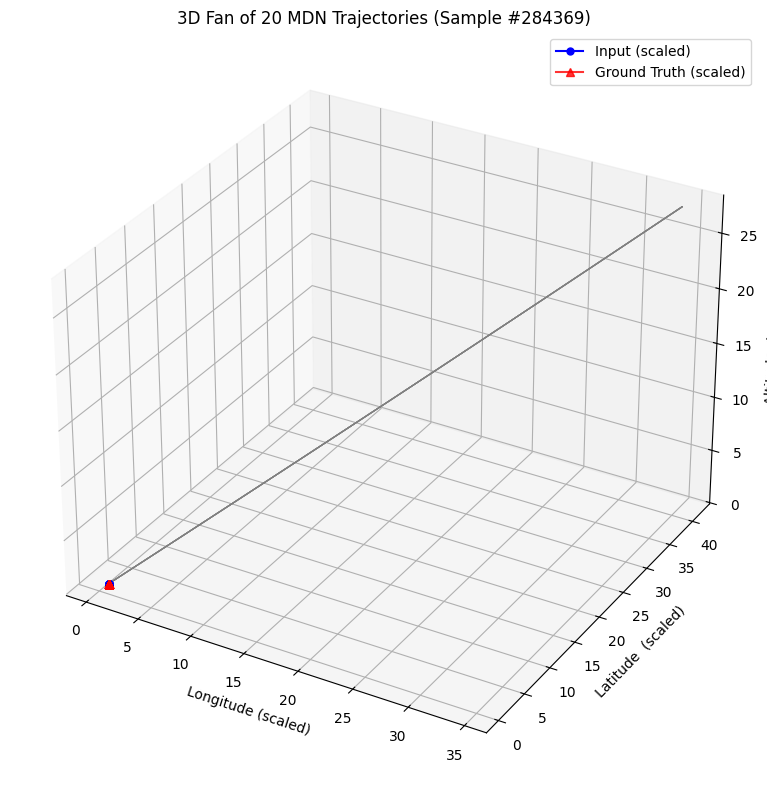

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx  = random.randint(0, len(test_var) - 1)      
K           = 20
sigma_temp  = 0.005

# ─── Constants from your setup ────────────────────────────────────────────
TIME_STEPS_IN  = test_var.shape[1]
TIME_STEPS_OUT = test_out.shape[1]
OUTPUT_DIM     = OUTPUT_FEATURES   # 3: (lat, lon, alt)
NUM_MIXTURES   = NUM_MIXTURES     # e.g. 7

# ─── 1) MDN predict + fan of deltas ───────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)
y_pred = model.predict((x_var, x_con))                
fan    = sample_fan(
    y_pred,
    output_dim=OUTPUT_DIM,
    num_mixes=NUM_MIXTURES,
    N_samples=K,
    temp=0.5,
    sigma_temp=sigma_temp
)  # shape (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history      = test_var[sample_idx, :, :OUTPUT_DIM]  # (T_hist,3)
y0           = history[-1]                          # (3,)
pred_samples = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

for k in range(K):
    deltas = fan[0, k]                           
    traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), float)
    traj[0]= y0                                  
    for t in range(1, TIME_STEPS_OUT):
        traj[t] = traj[t-1] + deltas[t]
    pred_samples[k] = traj

# ─── 3) Ground truth & history ────────────────────────────────────────────
gt         = test_out[sample_idx]    # (T_fut,3)
input_hist = history                  # (T_hist,3)

# ─── 4) Plot in 3D ────────────────────────────────────────────────────────
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111, projection='3d')

# a) sampled fans
for k in range(K):
    traj = pred_samples[k]
    ax.plot(
        traj[:,1],    # longitude
        traj[:,0],    # latitude
        traj[:,2],    # altitude
        color='gray',
        alpha=0.3,
        linewidth=0.8
    )

# b) input history
ax.plot(
    input_hist[:,1], input_hist[:,0], input_hist[:,2],
    'bo-', label="Input (scaled)", markersize=5
)

# c) ground truth future
ax.plot(
    gt[:,1], gt[:,0], gt[:,2],
    'r^-', label="Ground Truth (scaled)", alpha=0.8, markersize=6
)

ax.set_xlabel("Longitude (scaled)")
ax.set_ylabel("Latitude  (scaled)")
ax.set_zlabel("Altitude  (scaled)")
ax.set_title(f"3D Fan of {K} MDN Trajectories (Sample #{sample_idx})")
ax.legend()
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import plotly.graph_objs as go
import random

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx  = random.randint(0, len(test_var) - 1)      
K           = 20
sigma_temp  = 0.005

# ─── Constants from your setup ────────────────────────────────────────────
TIME_STEPS_IN  = test_var.shape[1]
TIME_STEPS_OUT = test_out.shape[1]
OUTPUT_DIM     = OUTPUT_FEATURES
NUM_MIXTURES   = NUM_MIXTURES

# ─── 1) MDN predict + fan of deltas ───────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)
y_pred = model.predict((x_var, x_con))                
fan    = sample_fan(
    y_pred,
    output_dim=OUTPUT_DIM,
    num_mixes=NUM_MIXTURES,
    N_samples=K,
    temp=0.5,
    sigma_temp=sigma_temp
)  # shape (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history      = test_var[sample_idx, :, :OUTPUT_DIM]
y0           = history[-1]
pred_samples = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

for k in range(K):
    deltas = fan[0, k]                           
    traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), float)
    traj[0]= y0                                  
    for t in range(1, TIME_STEPS_OUT):
        traj[t] = traj[t-1] + deltas[t]
    pred_samples[k] = traj

# ─── 3) Ground truth & history ────────────────────────────────────────────
gt         = test_out[sample_idx]
input_hist = history

# ─── 4) Plot with Plotly ──────────────────────────────────────────────────
fig = go.Figure()

# a) sampled fans
for k in range(K):
    traj = pred_samples[k]
    fig.add_trace(go.Scatter3d(
        x=traj[:,1], y=traj[:,0], z=traj[:,2],
        mode='lines',
        line=dict(color='gray', width=2),
        opacity=0.3,
        name=f'Sample {k}' if k == 0 else None,  # Only label the first
        showlegend=(k == 0)
    ))

# b) input history
fig.add_trace(go.Scatter3d(
    x=input_hist[:,1], y=input_hist[:,0], z=input_hist[:,2],
    mode='lines+markers',
    line=dict(color='blue', width=4),
    marker=dict(size=4, color='blue'),
    name='Input (scaled)'
))

# c) ground truth
fig.add_trace(go.Scatter3d(
    x=gt[:,1], y=gt[:,0], z=gt[:,2],
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=5, color='red', symbol='diamond'),
    name='Ground Truth (scaled)',
    opacity = 0.5
))

# Layout settings
fig.update_layout(
    scene=dict(
        xaxis_title="Longitude (scaled)",
        yaxis_title="Latitude (scaled)",
        zaxis_title="Altitude (scaled)"
    ),
    title=f"3D Fan of {K} MDN Trajectories (Sample #{sample_idx})",
    margin=dict(l=0, r=0, b=0, t=30),
    legend=dict(x=0, y=1)
)

fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


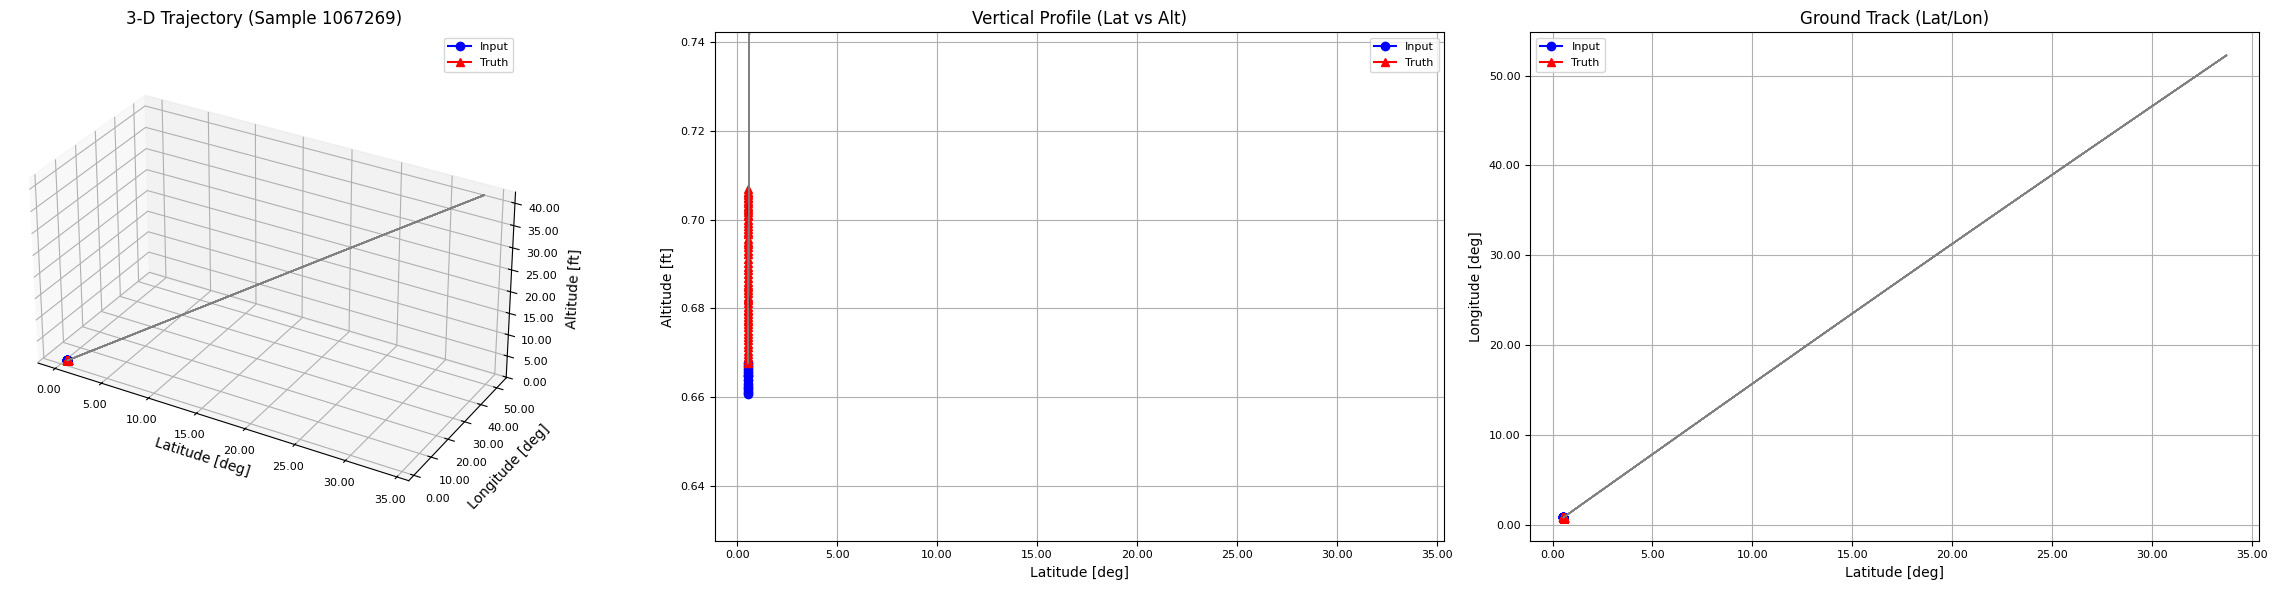

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ─── User parameters ─────────────────────────────────────────────────────
sample_idx   = random.randint(0, len(test_var) - 1)
K            = 50
sigma_temp   = 0.002

# ─── Constants from your setup ────────────────────────────────────────────
TIME_STEPS_IN   = test_var.shape[1]
TIME_STEPS_OUT  = test_out.shape[1]
OUTPUT_DIM      = OUTPUT_FEATURES # should be 3 (lat, long, alt)
NUM_MIXTURES    = NUM_MIXTURES

# ─── 1) MDN predict + fan of deltas ───────────────────────────────────────
x_var = test_var[sample_idx:sample_idx+1]              
x_con = np.squeeze(test_con[sample_idx:sample_idx+1], axis=1)

y_pred = model.predict((x_var, x_con))                
fan    = sample_fan(
    y_pred,
    output_dim   = OUTPUT_DIM,
    num_mixes    = NUM_MIXTURES,
    N_samples    = K,
    temp         = 0.5,
    sigma_temp   = sigma_temp
)  # shape (1, K, T_fut, 3)

# ─── 2) Reconstruct absolute trajectories ─────────────────────────────────
history      = test_var[sample_idx, :, :OUTPUT_DIM]  
y0           = history[-1]                          
pred_samples = np.zeros((K, TIME_STEPS_OUT, OUTPUT_DIM), dtype=np.float32)

for k in range(K):
    deltas = fan[0, k]                           
    traj   = np.zeros((TIME_STEPS_OUT, OUTPUT_DIM), float)
    traj[0]= y0                                  
    for t in range(1, TIME_STEPS_OUT):
        traj[t] = traj[t-1] + deltas[t]
    pred_samples[k] = traj

# ─── 3) Extract ground truth & history ────────────────────────────────────
gt          = test_out[sample_idx]
input_hist  = history

# Unpack coordinates
x_in, y_in, z_in       = input_hist[:, 0], input_hist[:, 1], input_hist[:, 2]
x_true, y_true, z_true = gt[:, 0], gt[:, 1], gt[:, 2]
best_unscaled          = pred_samples  # shape: (K, T_fut, 3)

# Optional formatter (if needed for nicer axis formatting)
fmt = ticker.FuncFormatter(lambda x, _: f"{x:.2f}")

# Create a figure with 3 subplots
fig = plt.figure(figsize=(24, 6))

# ───── 1) 3D Trajectory ─────────────────────────────────────────────
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(x_in, y_in, z_in, 'bo-', label='Input')
ax1.plot(x_true, y_true, z_true, 'r^-', label='Truth')

for samp in best_unscaled:
    ax1.plot(samp[:, 0], samp[:, 1], samp[:, 2], color='gray', alpha=0.2, linewidth=1)

#ax1.scatter(x_in[-1], y_in[-1], z_in[-1], c='k', marker='s', s=60, label='Overlap')

ax1.set_title(f"3-D Trajectory (Sample {sample_idx})")
ax1.set_xlabel("Latitude [deg]");   ax1.xaxis.set_major_formatter(fmt)
ax1.set_ylabel("Longitude [deg]");  ax1.yaxis.set_major_formatter(fmt)
ax1.set_zlabel("Altitude [ft]");    ax1.zaxis.set_major_formatter(fmt)
ax1.legend(fontsize=8); ax1.tick_params(labelsize=8)
ax1.set_box_aspect([2, 1, 1])  # Optional: adjusts 3D aspect ratio

# ───── 2) Vertical Profile (Latitude vs Altitude) ──────────────────
ax2 = fig.add_subplot(132)
ax2.plot(x_in, z_in, 'bo-', label='Input')
ax2.plot(x_true, z_true, 'r^-', label='Truth')

for samp in best_unscaled:
    ax2.plot(samp[:, 0], samp[:, 2], color='gray', alpha=0.2, linewidth=1)

#ax2.axvline(x_in[-1], color='k', ls='--', label='Overlap')

ax2.set_title("Vertical Profile (Lat vs Alt)")
ax2.set_xlabel("Latitude [deg]");   ax2.xaxis.set_major_formatter(fmt)
ax2.set_ylabel("Altitude [ft]");    ax2.yaxis.set_major_formatter(fmt)
ax2.grid(True); ax2.legend(fontsize=8); ax2.tick_params(labelsize=8)

factor = 0.05
ax2.set_ylim(np.min(input_hist[:,2]) * (1-factor), np.max(gt[:,2]) * (1+factor))

# ───── 3) Ground Track (Latitude vs Longitude) ─────────────────────
ax3 = fig.add_subplot(133)
ax3.plot(x_in, y_in, 'bo-', label='Input')
ax3.plot(x_true, y_true, 'r^-', label='Truth')

for samp in best_unscaled:
    ax3.plot(samp[:, 0], samp[:, 1], color='gray', alpha=0.2, linewidth=1)

#ax3.scatter(x_in[-1], y_in[-1], c='k', marker='s', s=60, label='Overlap', zorder=10)

ax3.set_title("Ground Track (Lat/Lon)")
ax3.set_xlabel("Latitude [deg]");   ax3.xaxis.set_major_formatter(fmt)
ax3.set_ylabel("Longitude [deg]");  ax3.yaxis.set_major_formatter(fmt)
ax3.grid(True); ax3.legend(fontsize=8); ax3.tick_params(labelsize=8)

# ───── Final layout and display ────────────────────────────────────
plt.tight_layout()
plt.show()


#413866